In [1]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt

sns.set(style="darkgrid")

from statsmodels.tsa.stattools import adfuller
from statsmodels.tsa.statespace.sarimax import SARIMAX
from sklearn.metrics import mean_squared_error, mean_absolute_error
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
from sklearn.linear_model import LogisticRegressionCV
from statsmodels.tsa.arima_model import ARIMA
from statsmodels.tsa.statespace.varmax import VARMAX

In [2]:
houston_emp = pd.read_csv('../project-4/SeriesReport-20190117124932_d3c517.csv')

In [3]:
houston_emp.head()

,Series ID,Year,Period,Value
0,SMU48264200000000001,1990,M01,1708.4
1,SMU48264200000000001,1990,M02,1724.9
2,SMU48264200000000001,1990,M03,1739.3
3,SMU48264200000000001,1990,M04,1756.5
4,SMU48264200000000001,1990,M05,1781.4


In [4]:
new_index = pd.date_range(start = '1/1/1990', periods = len(houston_emp), freq = 'MS')

houston_emp['time'] = new_index

houston_emp.set_index('time', inplace = True)

In [5]:
houston_emp['Value_Diff'] = houston_emp['Value'].diff()

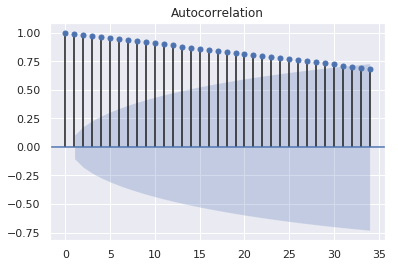

In [6]:
plot_acf(houston_emp['Value'], lags = (len(houston_emp) / 10));

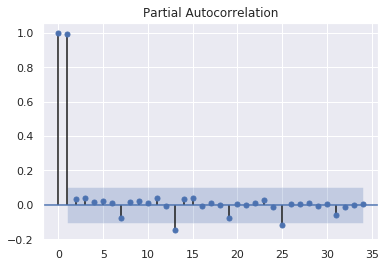

In [7]:
plot_pacf(houston_emp['Value'], lags = (len(houston_emp) / 10));

In [8]:
# Define function to easily interpret results.
def interpret_dftest(dftest):
    dfoutput = pd.Series(dftest[0:2], index=['Test Statistic','p-value'])
    return dfoutput

In [9]:
# Execute test on training data.
interpret_dftest(adfuller(houston_emp['Value'].dropna()))

Test Statistic    0.262663
p-value           0.975565
dtype: float64

In [10]:
stop_row = houston_emp.shape[0] - 23
test_start = stop_row
test_end = houston_emp.shape[0]

In [11]:
train = houston_emp.iloc[:stop_row]
test = houston_emp.iloc[stop_row:]

In [12]:
sarima = SARIMAX(endog = train['Value'],
                 order = (1, 0, 1),              # (p, d, q)
                 seasonal_order = (1, 0, 1, 30),
                 enforce_stationarity = False,
                 enforce_invertibility = False)  # (P, D, Q, S)

# Fit SARIMA model.
model = sarima.fit()

# Generate predictions based on test set.
preds = model.predict(start = test_start, end = test_end - 1)

# Evaluate predictions.
print(mean_absolute_error(test['Value'], preds))

/Users/ashleywhite/anaconda3/lib/python3.6/site-packages/statsmodels/tsa/base/tsa_model.py:171: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)
/Users/ashleywhite/anaconda3/lib/python3.6/site-packages/statsmodels/base/model.py:508: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


22.343894214962603


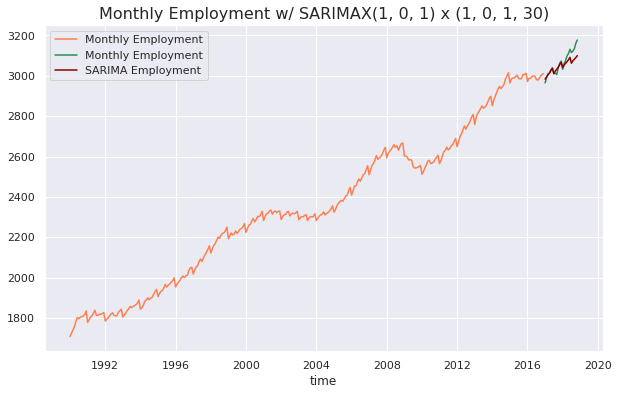

In [13]:
# Plot data.
plt.figure(figsize=(10,6))
plt.title(label = 'Monthly Employment w/ SARIMAX(1, 0, 1) x (1, 0, 1, 30)', fontsize=16);
sns.lineplot(data=train['Value'], color="coral", label="Monthly Employment")
sns.lineplot(data=test['Value'], color="seagreen", label="Monthly Employment")
sns.lineplot(x = test.index, y = preds.values, color = 'darkred', label = 'SARIMA Employment')

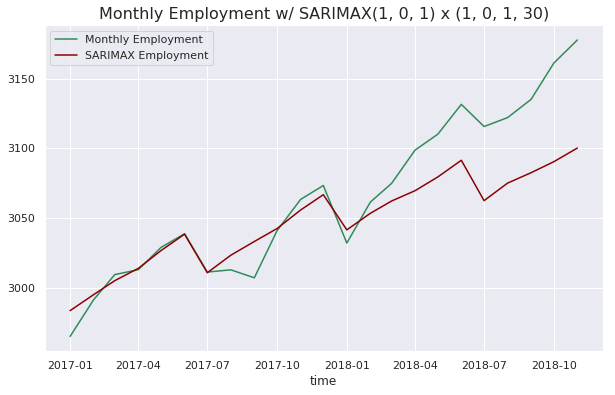

In [14]:
# Plot data.
plt.figure(figsize=(10,6))
plt.title(label = 'Monthly Employment w/ SARIMAX(1, 0, 1) x (1, 0, 1, 30)', fontsize=16);
#sns.lineplot(data=train['Value'], color="coral", label="Monthly Unemployment")
sns.lineplot(data=test['Value'], color="seagreen", label="Monthly Employment")
sns.lineplot(x = test.index, y = preds.values, color = 'darkred', label = 'SARIMAX Employment')

In [15]:
preds = pd.DataFrame(preds, columns= ['Predicted Value'])

In [16]:
houston_emp_preds = houston_emp.join(preds, on = houston_emp.index)

In [17]:
houston_emp_preds['dif'] = houston_emp_preds['Value'] - houston_emp_preds['Predicted Value']

In [18]:
houston_emp_preds.tail(25)

,Series ID,Year,Period,Value,Value_Diff,Predicted Value,dif
time,,,,,,,
2016-11-01,SMU48264200000000001,2016,M11,3007.3,8.3,NaN,NaN
2016-12-01,SMU48264200000000001,2016,M12,3010.5,3.2,NaN,NaN
2017-01-01,SMU48264200000000001,2017,M01,2965.1,-45.4,2983.608085,-18.508085
2017-02-01,SMU48264200000000001,2017,M02,2991.4,26.3,2995.078388,-3.678388
2017-03-01,SMU48264200000000001,2017,M03,3009.5,18.1,3005.146415,4.353585
2017-04-01,SMU48264200000000001,2017,M04,3013.0,3.5,3013.963148,-0.963148
2017-05-01,SMU48264200000000001,2017,M05,3029.0,16.0,3026.734171,2.265829
2017-06-01,SMU48264200000000001,2017,M06,3038.8,9.8,3038.490508,0.309492
2017-07-01,SMU48264200000000001,2017,M07,3011.3,-27.5,3010.830155,0.469845


In [19]:
houston_emp_preds.to_csv('../project-4/houston_employment_preds.csv')